In [1]:
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt
from astropy import units as u
from astropy import constants as const
from scipy.integrate import quad
from scipy.optimize import curve_fit
import matplotlib.patches as patches


# Cross section $pp$-interactions

In [2]:
def cross_section(E):
    L = np.log(E/1e3)
    E_th = 1.22
    return (34.3+1.88*L+0.25*pow(L,2))*pow((1-pow((E_th/E),4)),2)

In [4]:
E_cross1 = np.arange(2,20,0.01)
E_cross2 = np.arange(20,8e5,10)

(array([20., 25., 30., 35., 40., 45., 50., 55., 60.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

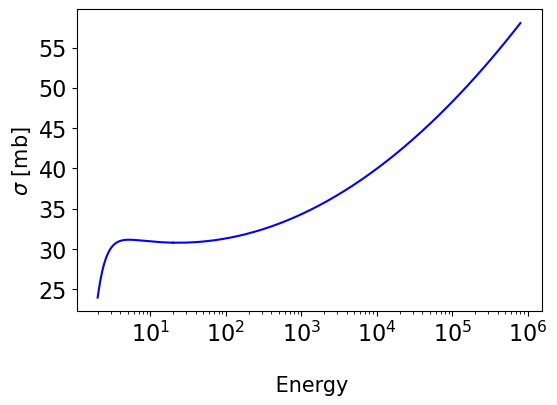

In [5]:
fig=plt.figure(figsize=(6,4), dpi= 100, facecolor='w', edgecolor='k')

plt.plot(E_cross1, cross_section(E_cross1), 'b')
plt.plot(E_cross2, cross_section(E_cross2),'b')
plt.xscale('log')
plt.xlabel('\n Energy', fontsize = 15)
plt.ylabel('$\sigma$ [mb]', fontsize = 15)
plt.xticks(fontsize= 16)
plt.yticks(fontsize= 16)

# Diffusion

## Quasi-linear formalism 

The diffusion model used in this work is inspired by the quasi-linear formalism: 
\begin{equation}
    D_A = \frac{r_L v}{3 \mathcal{F}(k)} \to \tau_{diff} = \frac{R^2}{D_A(p)} = 3\frac{R^2 \mathcal{F}(k)}{r_L(p)v(p)}
    \label{diffusion}
\end{equation}

with $R$ the radius of the staburst nucleus, $D(p)$ the diffusion coefficient, $r_{L}(p) /\mathrm {meter} =3.3 \times {\frac {(\gamma mc^{2}/\mathrm {GeV} )(v_{\perp }/c)}{(|q|/e)(B/\mathrm {Tesla} )}}$ the Larmor radius, $v(p)$ the speed of the cosmic ray, and $\mathcal{F}(k)$ the normalized energy
density of turbulent magnetic fields per unit logarithmic
wavenumber. This last parameter is defined as 
\begin{equation}
    \mathcal{F}(k) = k \cdot W(k) = k \cdot W_0\left(\frac{k}{k_0}\right)^{-d},
\end{equation}

with $k_0 = L_0^{-1}$ and $L_0$ the characteristic length scale at which turbulence is injected and calcultated via normalization condition
\begin{equation}
    \begin{split}
    & \int_{k_0}^{\infty} \mathcal{F}(k) \mathrm{d}(\mbox{ln}k) = \int_{k_0}^{\infty} W(k) dk = \left(\frac{\delta B}{B}\right)^2 = \eta_B \\
    &\iff \int_{k_0}^{\infty} W_0\left(\frac{k}{k_0}\right)^{-d} dk = \eta_B \\
    &\iff W_0 = \eta_B \cdot \left( k_0^d \int_{k_0}^{\infty} k^{-d} dk\right)^{-1}
    \end{split}
\end{equation}


As we consider CR injection via supernova activity, we can take the average size of a supernova remnant or the average size between two supernovae as $k_0$. 

Interpretation of the diffusion coefficient: The time over which an injected cosmic ray diffuses from the starburst nucleus scales with $\mathcal{F}(k)$. The more energy there is in the turbulent magnetic field, the more the particle is expected to random walk within the medium. This eventally leads to larger timescales over which diffusion would occur.



In [6]:
def larmor(E,B): #Larmor radius in m 
    B_G = (B*u.G)*1e-6 #Gauss
    B_T = (B_G.to(u.T)).value #Tesla
    return 3.3 *((E*1)/(1*B_T)) #https://en.wikipedia.org/wiki/Gyroradius


def W_0_trapz(k_0,d): #integration via Trapezium method
    integral = lambda k,d: pow(k,-d)
    logaxis = np.logspace(np.log10(1),np.log10(1e10),100000)
    I = np.trapz(integral(logaxis,d),logaxis)
    return pow(pow(k_0,d)*I,-1)


def F(k,k_0,d):
    return k*W_0_trapz(k_0,d)*pow(k/k_0,-d)


def D(E,k_0,B,d):
    c = (const.c).value # lightspeed in m/s
    
    k_m = 1/(larmor(E,B)*u.m) # in m^-1
    
    k_pc = (k_m.to(pow(u.parsec,-1))).value # in pc^-1
        
    D_m2_s = ((larmor(E,B)*c)/(3*F(k_pc,k_0,d)))*(pow(u.m,2)/u.s) #in m^2/s
    
    D_pc2_yr = (D_m2_s.to(pow(u.pc,2)/u.year)).value
    
    return D_pc2_yr # in pc^2/yr

def tau_diff_quasi(E,k_0,B,d,h):
    #This uses the diffusion coefficient in Peretti et al which is based on quasi-linear formalism
    return pow(h,2)/D(E,k_0,B,d)



## Diffusion model NGC 4945 paper

In [7]:
def time_diff(E,D_0,delta,h):
    h_pc = h*u.parsec
    h_cm = (h_pc.to(u.cm)).value # to cm 
    D = D_0*pow(E/3, delta) # D_0 in cm^2 s^-1
    t_diff_s = ((3*pow(h_cm,2))/(4*D))*u.second
    t_diff = (t_diff_s.to(u.yr)).value#*1e-6
    return t_diff

def func(x,a,b):
    return a*x+b

## Diffusion plots

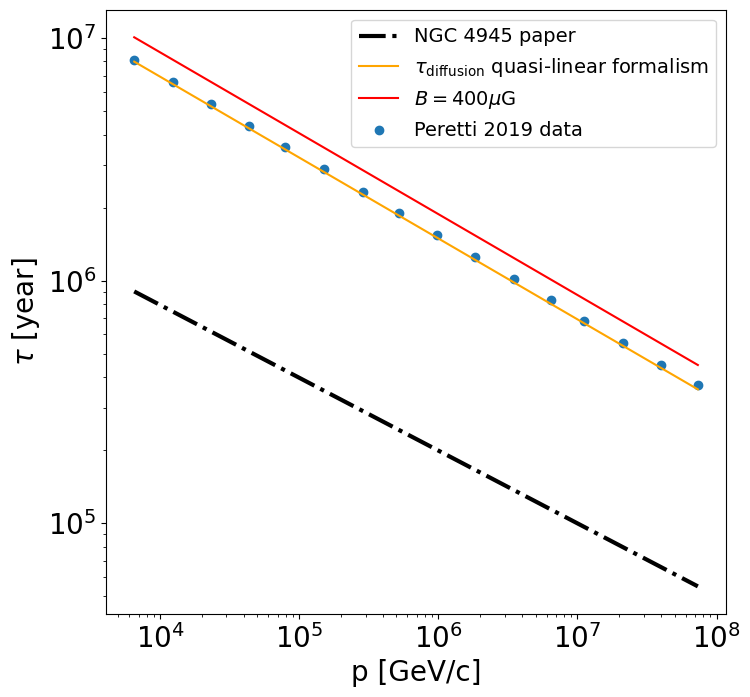

In [8]:
fig=plt.figure(figsize=(8,8), dpi= 100, facecolor='w', edgecolor='k')

R = 200 # pc
k0 = 1 #pc^-1
B = 200 # mG
d = 5/3 #Expected from Kolmogorov Turbulence

Peretti_momentum = np.loadtxt("Peretti_diff_momentum.txt")
Peretti_timescale = np.loadtxt("Peretti_diff_time.txt")
E= np.arange(min(Peretti_momentum),max(Peretti_momentum),1e3)


plt.plot(E, time_diff(E,1e27, 0.3, 200), label = 'NGC 4945 paper', color = 'k', linestyle = 'dashdot',linewidth = 3)
plt.plot(E, tau_diff_quasi(E,k0,B,d,R) ,'orange', label ='$\\tau_{\mathrm{diffusion}}$ quasi-linear formalism')
plt.plot(E, tau_diff_quasi(E,k0,400,d,R) ,'red', label ='$ B = 400 \mu$G') #B = 400 muG
plt.scatter(Peretti_momentum, Peretti_timescale, label = 'Peretti 2019 data')




plt.legend(fontsize = 14)
plt.xticks(fontsize= 20)
plt.yticks(fontsize= 20)
plt.ylabel('$\\tau$ [year]', fontsize= 20)
plt.xlabel('p [GeV/c]', fontsize= 20)
plt.xscale('log')
plt.yscale('log')

These two lines are not parallel as the approach of Peretti et al assumes a coefficient which is $\delta$ = 1/3 and the one from the NGC 4945 paper adopts $\delta$ = 0.3. 

Here we investigate the effect of changing $k_0$ by computing $\tau_{\mathrm{diff}}$ for $k_0 = 1$ pc$^{-1}$ and $k_0 = 2$ pc$^{-1}$ and normalize it to $\tau_{\mathrm{diff}}$(1 pc$^{-1}$)

Doubling the characterisitc length therefore decreases the diffusion time.
! Still thinking about this.

# Timescales: diffusion, $pp$-collisions, and advection

In [9]:
def pp_col(E,n): #(GeV,cm-3)
    kappa = 0.5 #inelasticity: the energy lost in a pp-collision
    c_cm = const.c.value*1e2 #cm/s
    t_col_s = pow(kappa*cross_section(E)*1e-27*n*c_cm,-1)*u.second #1e-27 to convert mb -> cm2
    t_col = ((t_col_s.to(u.yr)).value)
    return t_col #collision time in years

In [10]:
def advection(h,V): #(pc,km/s)
    h_pc = h*u.parsec
    h_km = (h_pc.to(u.km)).value
    t_adv_s = (h_km/V)*u.second
    t_adv_year = (t_adv_s.to(u.yr)).value
    return (t_adv_year) #advection in years

In [11]:
def total_tau(E,n,h,V,D0,delta,B,diffmodel):
    if diffmodel == 'Kolmogorov Peretti': #in years
        return pow(pow(advection(h,V),-1)+pow(tau_diff_quasi(E,1,B,5/3,h),-1)+pow(pp_col(E,n),-1),-1)
        
    if diffmodel == 'NGC 4945':
        return pow(pow(advection(h,V),-1)+pow(time_diff(E,D0,delta,h),-1)+pow(pp_col(E,n),-1),-1)
    
    if diffmodel == 'no diff':
        return pow(pow(advection(h,V),-1)+pow(pp_col(E,n),-1),-1)
    


In [12]:
def t_esc(E,h,V,B):
    return pow(pow(advection(h,V),-1)+pow(tau_diff_quasi(E,1,B,5/3,h),-1),-1)
        

# Case study: Arp 299-A

## Volume density 

* ISM denisty found in [0] for a spherical volume, is $n = 1200$ cm$^{-3}$. 


* Hydrodynamic simulations of mergers between gas-rich galaxies predict formation of nuclear gas disks on scales of $\sim$10$-$100 pc (e.g.$~$[1]). Observational evidence for such gas disks in the nuclear region of GOALS U/LIRGs is provided by a survey targeting 17 nearby U/LIRGs [2]. Within this gas-disk configuration, stars are formed which eventually explode as supernovae and thereby inject cosmic rays into the nuclear ISM. Based on these simulations and observations, we choose for a disk geometry to model the volume in which cosmic rays propagate. This disk is parameterized by a radius $R_{\mathrm{SBR}}$ and a scale height $H_{\mathrm{SBR}}$. This implies that the volume of the starburst region is computed as $V_{\mathrm{SBR}} = 2 H_{\mathrm{SBR}} \pi R^2_{\mathrm{SBR}}$, with $2H_{\mathrm{SBR}}$ the total thickness of the nuclear disk. 

[0] : https://articles.adsabs.harvard.edu/cgi-bin/nph-iarticle_query?1991ApJ...366L...1S&defaultprint=YES&filetype=.pdf

[1] : https://arxiv.org/abs/0807.3329

[2] : https://arxiv.org/abs/1401.7338

In [13]:
def n_H2(M,R,h,string):
    M_H2 = M*u.solMass
    mp = (const.m_p).to(u.solMass) #proton mass in units of solar masses
    h_SBR = (h*u.pc).to(u.cm)
    R = (R*u.pc).to(u.cm)
    if string == 'sphere':
        V_sphere = (4/3)*np.pi*pow(R,3)
        n_sphere = M_H2/(2*mp*V_sphere)
        return n_sphere 

    else: 
        V_disk = 2*np.pi*h_SBR*pow(R,2)
        n_disk = M_H2/(2*mp*V_disk)
        return n_disk
    

print("Nuclear ISM particle density in Arp 299-A for spherical geometry", n_H2(3.9e9,250,150,'sphere'))
print("Nuclear ISM particle density in Arp 299-A for disk geometry", n_H2(3.9e9,250,150,'spere'))


Nuclear ISM particle density in Arp 299-A for spherical geometry 1205.5423341670448 1 / cm3
Nuclear ISM particle density in Arp 299-A for disk geometry 1339.4914824078273 1 / cm3


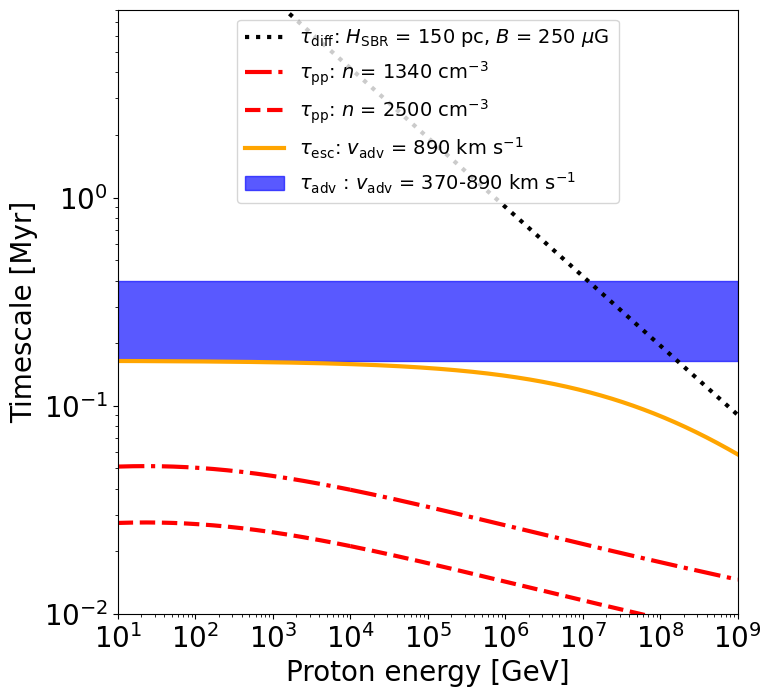

In [14]:
fig=plt.figure(figsize=(8,8), dpi= 100, facecolor='w', edgecolor='k')

Energy = np.logspace(np.log10(10), np.log10(1e4), 1000)#np.arange(10, 1e4, 0.1)
Energy2 = np.logspace(np.log10(1e4), np.log10(1e9), 1000) #np.arange(1e4,1e9,1e3)
Ediff = np.logspace(np.log10(1), np.log10(1e9), 1000) #np.arange(1,1e9,1e3)
 
vadv1 = 370
vadv2 = 890
HSBRplot = 150
nismH2 = 1340
nismH = 2500
Bplot = 250


plt.plot(Ediff,tau_diff_quasi(Ediff,1,Bplot,5/3,HSBRplot)/1e6,c = 'black', label = '$\\tau_{\mathrm{diff}}$: $H_{\mathrm{SBR}}$ = 150 pc, $B$ = 250 $\mu \mathrm{G}$ ',linewidth = 3, linestyle = 'dotted')

plt.axhspan(advection(HSBRplot, vadv1)/1e6,advection(HSBRplot, vadv2)/1e6, color = 'blue', alpha = 0.65, 
            label = '$\\tau_{\mathrm{adv}}$ : $v_{\mathrm{adv}}$ = 370-890 km s$^{-1}$')

plt.plot(Energy, pp_col(Energy, nismH2)/1e6,c= 'r',linestyle = '-.',linewidth = 3, label = '$\\tau_{\mathrm{pp}}$: $n$ = 1340 cm$^{-3}$')
plt.plot(Energy2,pp_col(Energy2, nismH2)/1e6,c  = 'r', linestyle = '-.', linewidth = 3)

plt.plot(Energy, pp_col(Energy, nismH)/1e6,c= 'r',linestyle = '--',linewidth = 3, label = '$\\tau_{\mathrm{pp}}$: $n$ = 2500 cm$^{-3}$')
plt.plot(Energy2,pp_col(Energy2, nismH)/1e6,c  = 'r', linestyle = '--', linewidth = 3)

plt.plot(Ediff,t_esc(Ediff,HSBRplot,vadv2,Bplot)/1e6, c= 'orange', linewidth = 3,label = '$\\tau_{\mathrm{esc}}$: $v_{\mathrm{adv}}$ = 890 km s$^{-1}$  ')





plt.xlabel('Proton energy [GeV]', fontsize = 20)
plt.ylabel('Timescale [Myr]', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.xscale('log')
plt.yscale('log')
plt.xlim(10,1e9)
plt.ylim(1e4/1e6,8e6/1e6)
plt.legend(fontsize = 14,loc = "upper center")
plt.savefig("/Users/yarno/Documents/PhD/Pictures/timescale.png",bbox_inches="tight")


##  Calorimeter conditions: heatmap ($\mathcal{C}$)

In [15]:
def C_cal(E,n,V,H,D0,delta,B,diffmodel):
        
        if diffmodel == 'Kolmogorov Peretti':
            return total_tau(E,n,H,V,D0,delta, B,'Kolmogorov Peretti')/pp_col(E,n)
        
        elif diffmodel == 'no diff': 
            return total_tau(E,n,H,V,D0,delta, B , 'no diff')/pp_col(E,n)

        
        elif diffmodel == 'NGC 4945':
            return total_tau(E,n,H,V,D0,delta, B ,'NGC 4945')/pp_col(E,n)
        
        
        else:
            print('No valid diffusion model was given')

In [16]:
x = np.arange(1,10001,1)
y = np.arange(10,2500,1)
X, Y = np.meshgrid(x, y)
Z_nodiff = C_cal(1e7,X,Y,150,0,0,250,'no diff')
Z_Kolmogorov = C_cal(1e7,X,Y,150,0,0,250,'Kolmogorov Peretti')


### Kolmogorov diffusion

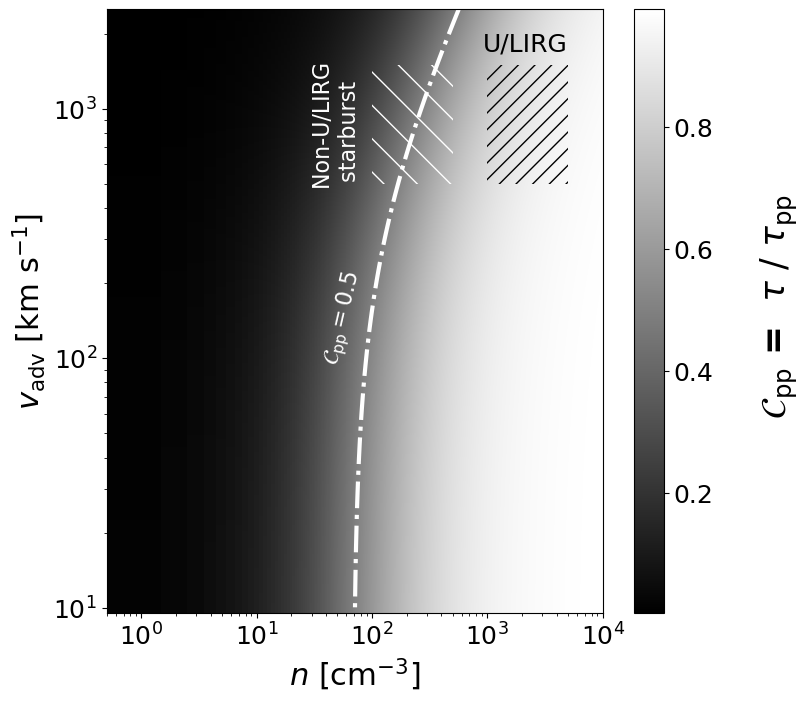

In [17]:
fig = plt.figure(figsize=(8,8), dpi= 100, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)

pcm1 = plt.pcolormesh(x, y, Z_Kolmogorov,cmap = 'gray', shading='auto')
cb1 = fig.colorbar(pcm1)
cb1.ax.tick_params(labelsize= 18)
cb1.set_label(label = '\n $\mathcal{C}_{\mathrm{pp}}$ =  $\\tau~/~\\tau_{\mathrm{pp}}$',weight='bold', fontsize = 25)
cs_Kolmogorov = plt.contour(X, Y, Z_Kolmogorov, colors='white',linewidths = 3, linestyles = 'dashdot',levels = [0.5])

plt.text(35,100,s= '$\mathcal{C}_{\mathrm{pp}} = 0.5$', fontsize= 16, rotation = +77, color = 'white')
plt.text(9.2e2,1700, s= 'U/LIRG', c= 'k', fontsize = 18)
plt.text(30,500 , rotation= +90, s = 'Non-U/LIRG \n starburst', fontsize = 16, color = 'white')

rect1 = patches.Rectangle((1000, 500),
                                     4000, 1000,
                                      fill=None, hatch='//', lw = 0)

rect2 = patches.Rectangle((100, 500),
                                     400, 1000,
                                      fill=None, hatch='\\', lw = 0, color= 'white')


ax.add_patch(rect1)
ax.add_patch(rect2)

plt.ylabel("$v_{\mathrm{adv}}$ [km s$^{-1}$]",fontsize = 22)
plt.xlabel("$n$ [cm$^{-3}$]",fontsize = 22)
plt.xticks(fontsize = 18)
plt.yticks(fontsize= 18)

plt.xscale('log')
plt.yscale('log')
plt.savefig("/Users/yarno/Documents/PhD/Pictures/halp.png",bbox_inches="tight")


Choosing $\mathcal{C} = 0.5$ ensures that:
\begin{gather}
    \mathcal{C} = \frac{1}{2} \to
        \begin{cases}
        \label{pp}
         \quad \tau_{\mathrm{pp}} < \tau_{\mathrm{diff}} \land \tau_{\mathrm{pp}} < \tau_{\mathrm{adv}} \quad &\mbox{if $\tau^{-1}_{\mathrm{diff}} \neq 0$ $\land$ $\tau^{-1}_{\mathrm{adv}} \neq 0$ }\\
         \quad \tau_{\mathrm{pp}} = \tau_{\mathrm{diff}} \quad \quad &\mbox{$\tau^{-1}_{\mathrm{adv}} = 0$ }\\
         \quad \tau_{\mathrm{pp}} = \tau_{\mathrm{adv}} \quad & \mbox{$\tau^{-1}_{\mathrm{diff}} = 0$ }.
        \end{cases}
    \end{gather}
    
Therefore, for $\mathcal{C} \gtrsim 0.5$, the $pp$-collision timescale will be comparable or smaller than the loss timescales. This can be checked by extracting the (x,y) values from the contour at $\mathcal{C}$ = 0.5 and using these to compute the fraction of the timescales and divide by the $pp$-collision timescale. If $\mathcal{C}$ = 0.5 and no diffusion is taken into account, the the fractions should be 1. If $\mathcal{C} \geq$  0.5 and both diffusion and advection are taken into account, then the fractions shoudl always be larger than one. 

## $C_{\mathrm{pp}}$ as function of disk scale height

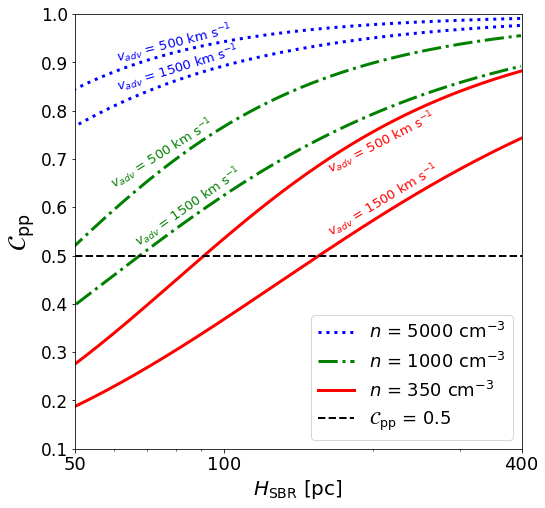

In [18]:
#fig=plt.figure(figsize=(8,8), dpi= 100, facecolor='w', edgecolor='k')
fig1, ax1 = plt.subplots(figsize=(8,8))

#import matplotlib.ticker 

scale_H = np.arange(10,400,1)


ax1.plot(scale_H,C_cal(1e7,5000,500,scale_H,0,0,250,"Kolmogorov Peretti"),linestyle = 'dotted',color= 'blue', label =  '$n$ = 5000 cm$^{-3}$',linewidth = 3)
ax1.plot(scale_H,C_cal(1e7,5000,1500,scale_H,0,0,250,"Kolmogorov Peretti"),linestyle = 'dotted',color= 'blue', linewidth = 3)

ax1.plot(scale_H,C_cal(1e7,1000,500,scale_H,0,0,250,"Kolmogorov Peretti"),'-.',color= 'green', label =  '$n$ = 1000 cm$^{-3}$',linewidth = 3)
ax1.plot(scale_H,C_cal(1e7,1000,1500,scale_H,0,0,250,"Kolmogorov Peretti"),'-.',color= 'green',linewidth = 3)


ax1.plot(scale_H,C_cal(1e7,350,500,scale_H,0,0,250,"Kolmogorov Peretti"), color ='red', label = '$n$ = 350 cm$^{-3}$',linewidth = 3)
ax1.plot(scale_H,C_cal(1e7,350,1500,scale_H,0,0,250,"Kolmogorov Peretti"),color ='red',linewidth = 3)


ax1.axhline(y=0.5, color = 'k',linestyle = 'dashed',linewidth = 2, label = '$\mathcal{C}_{\mathrm{pp}}$ = 0.5')

ax1.text(60,0.90, "$v_{adv}$ = 500 km s$^{-1}$", rotation = 14, color = 'blue', fontsize = 13)
ax1.text(60,0.84, "$v_{adv}$ = 1500 km s$^{-1}$", rotation = 17, color = 'blue', fontsize = 13)
ax1.text(58,0.64, "$v_{adv}$ = 500 km s$^{-1}$", rotation = 32, color = 'green', fontsize = 13)
ax1.text(65,0.52, "$v_{adv}$ = 1500 km s$^{-1}$", rotation = 35, color = 'green', fontsize = 13)
ax1.text(160,0.67, "$v_{adv}$ = 500 km s$^{-1}$", rotation = 27, color = 'red',fontsize = 13)
ax1.text(160,0.54, "$v_{adv}$ = 1500 km s$^{-1}$", rotation = 31, color = 'red', fontsize = 13)




ax1.legend( fontsize = 18, loc = 'lower right')
ax1.set_xlabel('$H_{\mathrm{SBR}}$ [pc] ', fontsize = 20)
ax1.set_ylabel('$\mathcal{C}_{\mathrm{pp}}$', fontsize = 25)
ax1.set_xscale('log')
ax1.set_yticks(np.arange(0,1.1,0.1))
ax1.set_xticks([50,100,400])
ax1.set_ylim(0.1,1,0.1)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 17)
plt.gca().xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax1.set_xlim(50,400)
from matplotlib.ticker import ScalarFormatter
ax1.xaxis.set_major_formatter(ScalarFormatter())
plt.savefig("/Users/yarno/Documents/PhD/Pictures/hsb.pdf",bbox_inches="tight")


## $C_{\mathrm{pp}}$ as function cosmic-ray energy

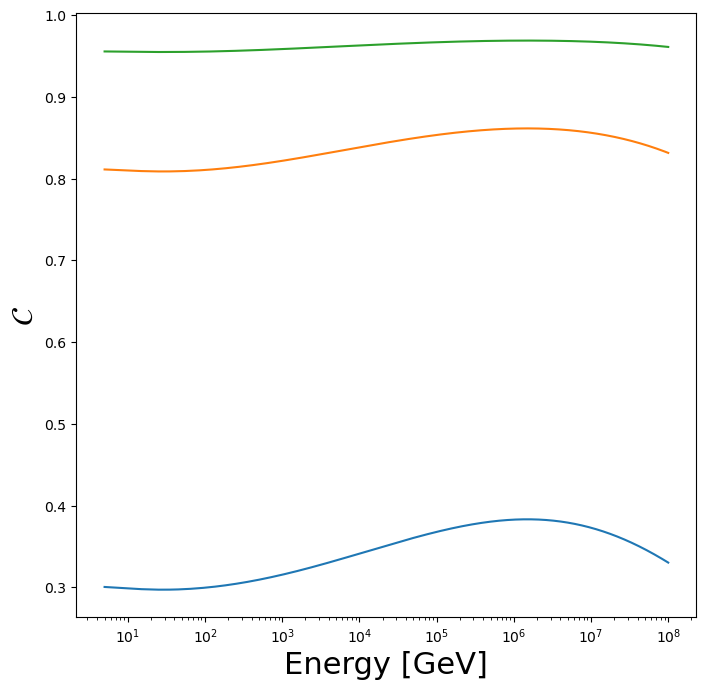

In [19]:
fig=plt.figure(figsize=(8,8), dpi= 100, facecolor='w', edgecolor='k')

energy = np.arange(5,1e8,10)
plt.plot(energy, C_cal(energy,100,500,150,0,0,250,'Kolmogorov Peretti'))
plt.plot(energy, C_cal(energy,1000,500,150,0,0,250,'Kolmogorov Peretti'))
plt.plot(energy, C_cal(energy,5000,500,150,0,0,250,'Kolmogorov Peretti'))

plt.xlabel('Energy [GeV]', fontsize = 22)
plt.ylabel('$\mathcal{C}$', fontsize = 22)
plt.xscale('log')

## Neutrino production efficiency

In the literature the efficiency of neutrino production from $pp$-interaction is typically characterised by the effective optical depth $f_{\mathrm{pp}}$ as
\begin{equation}
    f_{\mathrm{pp}} = \frac{\tau_{\mathrm{esc}}}{\tau_{\mathrm{pp}}}~,
\end{equation}

with the $\tau_{\mathrm{esc}}$ the timescale over which particle escape occurs. In this work $\tau_{\mathrm{esc}} = (\tau^{-1}_{\mathrm{diff}} + \tau^{-1}_{\mathrm{adv}})$. The relation between $f_{\mathrm{pp}}$ and $\mathcal{C}_{\mathrm{pp}}$ is given as
\begin{equation}
    \mathcal{C}_{\mathrm{pp}} = \frac{f_{\mathrm{pp}}}{f_{\mathrm{pp}}+1}~.
    \end{equation}
    
Proof relation $\mathcal{C}_{\mathrm{pp}}$ and $f_{\mathrm{pp}}$

\begin{align*}
    \tau_{\mathrm{pp}} \cdot \frac{f_{\mathrm{pp}}}{f_{\mathrm{pp}}+1}  &=  \frac{\tau_{\mathrm{esc}}\mathrm{\tau_{\mathrm{pp}}}}{\tau_\mathrm{esc}+ \tau_{\mathrm{pp}}} \\
    \\
    &= \frac{\tau_{\mathrm{adv}}\tau_{\mathrm{diff}}\tau_{\mathrm{pp}}}{\tau_{\mathrm{adv}}+ \tau_{\mathrm{diff}}} \cdot \frac{1}{\frac{\tau_{\mathrm{adv}} \tau_{\mathrm{diff}}}{\tau_{\mathrm{adv}}+ \tau_{\mathrm{diff}}}+ \tau_{\mathrm{pp}}}\\
    \\
    &= \frac{\tau_{\mathrm{adv}}\tau_{\mathrm{diff}}\tau_{\mathrm{pp}}}{\tau_{\mathrm{adv}}\tau_{\mathrm{diff}}+ \tau_{\mathrm{pp}}\tau_{\mathrm{adv}}+\tau_{\mathrm{pp}}\tau_{\mathrm{diff}}}\\
    \\
    &= (\tau^{-1}_{\mathrm{pp}}+\tau^{-1}_{\mathrm{adv}}+\tau^{-1}_{\mathrm{diff}})^{-1}\\
    \\ 
    &= \tau \iff \frac{\tau}{\tau_{\mathrm{pp}}} = \mathcal{C}_{\mathrm{pp}} = \frac{f_{\mathrm{pp}}}{f_{\mathrm{pp}}+1}~.
\end{align*}

Computational proof:

In [20]:
def fpp(E,k0,B,d,R, n, h, V):
    tauesc = pow(pow(tau_diff_quasi(E,k0,B,d,R),-1)+ pow(advection(h,V),-1),-1)
    taupp = pp_col(E,n)
    return tauesc/taupp

def Fcal(E,k0,B,d,R, n, h, V):
    return fpp(E,k0,B,d,R, n, h, V)/(fpp(E,k0,B,d, R, n, h, V)+1)

print('Fcal: ', round(Fcal(1e7, 1, 250,5/3, 200,1340, 200,700),3))
print('C: ', round(C_cal(1e7,1340,700,200,0,0,250,'Kolmogorov Peretti'),3))

Fcal:  0.904
C:  0.904


In [21]:
def efficiency_pp(E, n_in,t_escin):
    sigma = (cross_section(E)*1e-3*u.barn).to(pow(u.cm,2))
    c = (const.c).to(u.cm/u.s)
    n = n_in*pow(u.cm,-3)
    kappa = 0.5
    t = (t_escin*u.yr).to(u.s)
    return (c*n*sigma*kappa*t).value
    

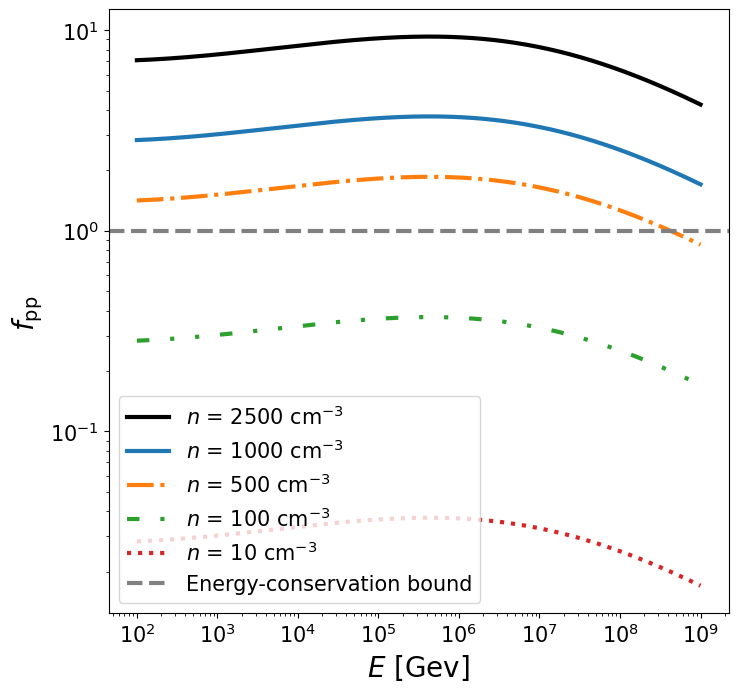

In [22]:
fig=plt.figure(figsize=(8,8), dpi= 100, facecolor='w', edgecolor='k')

E_eff_p = np.logspace(np.log10(1e2),np.log10(1e9),1000)
plt.plot(E_eff_p, efficiency_pp(E_eff_p, 2500, t_esc(E_eff_p,100,500,Bplot)), label = '$n$ = 2500 cm$^{-3}$', linewidth = 3, color = 'black' )
plt.plot(E_eff_p, efficiency_pp(E_eff_p, 1e3, t_esc(E_eff_p,100,500,Bplot)), label = '$n$ = 1000 cm$^{-3}$', linewidth = 3 )
plt.plot(E_eff_p, efficiency_pp(E_eff_p, 5e2, t_esc(E_eff_p,100,500,Bplot)), linestyle = '-.', label = '$n$ = 500 cm$^{-3}$', linewidth = 3)
plt.plot(E_eff_p, efficiency_pp(E_eff_p, 1e2, t_esc(E_eff_p,100,500,Bplot)), linestyle = ((0, (3, 5, 1, 5, 1, 5))), label = '$n$ = 100 cm$^{-3}$', linewidth = 3)
plt.plot(E_eff_p, efficiency_pp(E_eff_p, 1e1, t_esc(E_eff_p,100,500,Bplot)),label = '$n$ = 10 cm$^{-3}$', linestyle = 'dotted', linewidth = 3)
plt.axhline(y = 1, c= 'grey', label = 'Energy-conservation bound', linewidth = 3, linestyle = 'dashed')
plt.xlabel('$E$ [Gev]', fontsize = 20)
plt.ylabel('$f_{\mathrm{pp}}$ ', fontsize = 20)
plt.legend(fontsize = 15, loc = "best")
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xscale('log')
plt.yscale('log')
plt.savefig("/Users/yarno/Documents/PhD/Pictures/Extrapolation_plots/fpp.png",bbox_inches="tight")
